In [1]:
!pip install einops
from einops import rearrange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
!mv Dataset_Student_annot_copy.zip Dataset_Student_annot.zip
#https://drive.google.com/file/d/1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2/view?usp=share_link
!unzip Dataset_Student_annot.zip

Downloading...
From: https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
To: /content/Dataset_Student_annot_copy.zip
  7% 660M/10.1G [00:02<00:35, 266MB/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 444, in _error_catcher
    yield
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 567, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 533, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/usr/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 699, in readinto
    self._checkClosed()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/

In [16]:
!gdown https://drive.google.com/uc?id=1hw08A39sJY_qoTpTGGLL6yDV-4o9cWMY
#https://drive.google.com/file/d/1hw08A39sJY_qoTpTGGLL6yDV-4o9cWMY


Downloading...
From: https://drive.google.com/uc?id=1hw08A39sJY_qoTpTGGLL6yDV-4o9cWMY
To: /content/unlabeled_set_masks.zip
100% 208M/208M [00:01<00:00, 163MB/s]


In [18]:
!unzip unlabeled_set_masks.zip

Streaming output truncated to the last 5000 lines.
  inflating: output_masks/mask_10475.pt  
  inflating: output_masks/mask_5335.pt  
  inflating: output_masks/mask_1983.pt  
  inflating: output_masks/mask_5611.pt  
  inflating: output_masks/mask_10779.pt  
  inflating: output_masks/mask_12999.pt  
  inflating: output_masks/mask_6739.pt  
  inflating: output_masks/mask_1340.pt  
  inflating: output_masks/mask_5360.pt  
  inflating: output_masks/mask_3615.pt  
  inflating: output_masks/mask_6834.pt  
  inflating: output_masks/mask_2774.pt  
  inflating: output_masks/mask_4160.pt  
  inflating: output_masks/mask_4303.pt  
  inflating: output_masks/mask_1050.pt  
  inflating: output_masks/mask_9089.pt  
  inflating: output_masks/mask_7280.pt  
  inflating: output_masks/mask_3298.pt  
  inflating: output_masks/mask_10042.pt  
  inflating: output_masks/mask_3102.pt  
  inflating: output_masks/mask_5253.pt  
  inflating: output_masks/mask_12005.pt  
  inflating: output_masks/mask_12607.pt  


In [2]:
import torch
import torch.nn as nn

# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [3]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output


In [4]:
import torch.nn as nn
import torch

class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=49,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        #print(f"got to beginning: {X.shape}")
        # Forward propagation through all the layers
        output = self.sequential(X)

        #print(f"got to middle: {output.shape}")

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return output

In [90]:
! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy


^C


In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
import torch.nn.functional as F

def one_hot_encoding(input_tensor, num_classes=49):
    one_hot = F.one_hot(input_tensor.long(), num_classes)
    #print(one_hot.shape)
    one_hot = rearrange(one_hot, 'b f h w c -> b c f h w')  # Change the dimensions to (batch_size, num_classes, height, width)
    return one_hot

In [8]:
import os
import torch
from torch.utils.data import Dataset
from einops import rearrange

def collate(batch):

    batch = torch.cat(batch)

    # Add channel dim, scale pixels between 0 and 1, send to GPU

    #split input and target
    rand = np.random.randint(11,21)
    input = batch[:,rand-11:rand, :, :]
    target = batch[:,rand,:,:]
    input = one_hot_encoding(input, 49)             
    input, target = input.to(device), target.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target                   
    return input, target 

class MaskDataset(Dataset):
    def __init__(self, save_dir='output_masks'):
        self.save_dir = save_dir
        self.files = sorted([f for f in os.listdir(save_dir) if f.startswith('mask_') and f.endswith('.pt')])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mask_path = os.path.join(self.save_dir, self.files[idx])
        mask = torch.load(mask_path)
        #label = torch.tensor(0)  # Dummy label; replace with actual labels if needed
        return mask.unsqueeze(0) #, label

dataset = MaskDataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate)

In [14]:
# Load Data as Numpy Array
#MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
#np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
#train_data = MovingMNIST[:8000]         
#val_data = MovingMNIST[8000:9000]       
#test_data = MovingMNIST[9000:10000]     

#def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
#    batch = torch.tensor(batch).unsqueeze(1)     
#    batch = batch / 255.0                        
#    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
#    rand = np.random.randint(11,21)                     
#    return batch[:,:,rand-11:rand], batch[:,:,rand]     


# Training Data Loader
#train_loader = DataLoader(train_data, shuffle=True, 
#                        batch_size=16, collate_fn=collate)

# Validation Data Loader
#val_loader = DataLoader(val_data, shuffle=True, 
#                        batch_size=16, collate_fn=collate)

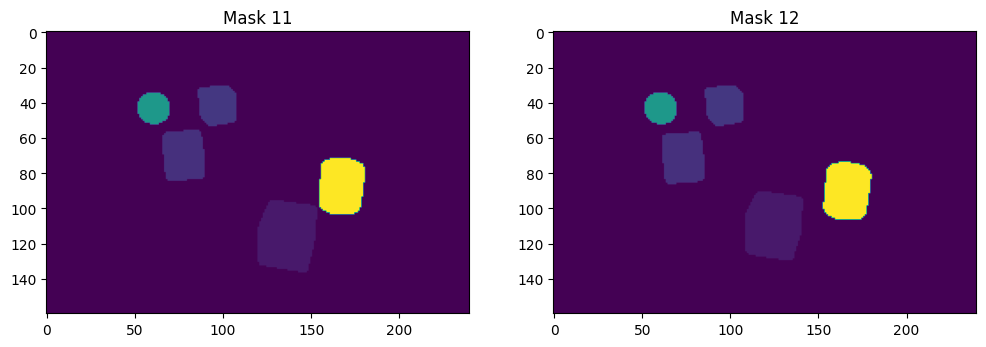

In [9]:
import matplotlib.pyplot as plt

# Get a batch
input, target = next(iter(dataloader))

input = input[0,:,10]
input = torch.argmax(input, dim=0)
#input = torch.argmax(input[0], dim=)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(input.cpu().numpy())
ax1.set_title("Mask 11")
ax2.imshow(target[0].cpu().numpy())
ax2.set_title("Mask 12")
plt.show()
# Reverse process before displaying
#input = input.cpu().numpy()  

#for video in input.squeeze(1)[:3]:          # Loop over videos
#    with io.BytesIO() as gif:
#        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
#        display(HBox([widgets.Image(value=gif.getvalue())]))

In [12]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
# The input video frames are 49 classes, thus 49 one-hot channels
model = Seq2Seq(num_channels=49, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(160, 240), num_layers=3).to(device)

num_epochs = 3
steps = num_epochs * len(dataloader)
optim = AdamW(model.parameters(), lr=1e-4, weight_decay=0.005)
scheduler = CosineAnnealingLR(optim, T_max=steps, eta_min=1e-8)

class_weights = torch.ones(49)
class_weights[0] = 0.3
class_weights = class_weights.to(device)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [13]:
from tqdm import tqdm

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch_num, (input, target) in pbar:
        #input, target = input.to(device), target.to(device)
        output = model(input)
        #print(output.shape)
        #print(target.shape)                            
        loss = criterion(output, target)       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        scheduler.step()
        pbar.set_description(f"Epoch:{epoch} Batch:{batch_num+1}/{len(dataloader)} Loss:{loss.item()}")
    
    print(output.shape)
    output_example = output[0,:]
    print(output_example.shape)
    output_example = torch.argmax(output_example, dim=0)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(output_example.cpu().numpy())
    ax1.set_title("Pred Mask 12")
    ax2.imshow(target[0].cpu().numpy())
    ax2.set_title("Actual 12")
    plt.show()

    train_loss /= len(dataloader.dataset)
    print(f"Epoch:{epoch} Training Loss:{train_loss}")


Epoch:1 Batch:1625/1625 Loss:0.07118695229291916: 100%|██████████| 1625/1625 [36:39<00:00,  1.35s/it]

torch.Size([8, 49, 160, 240])


TypeError: ignored

torch.Size([8, 49, 160, 240])
torch.Size([49, 160, 240])


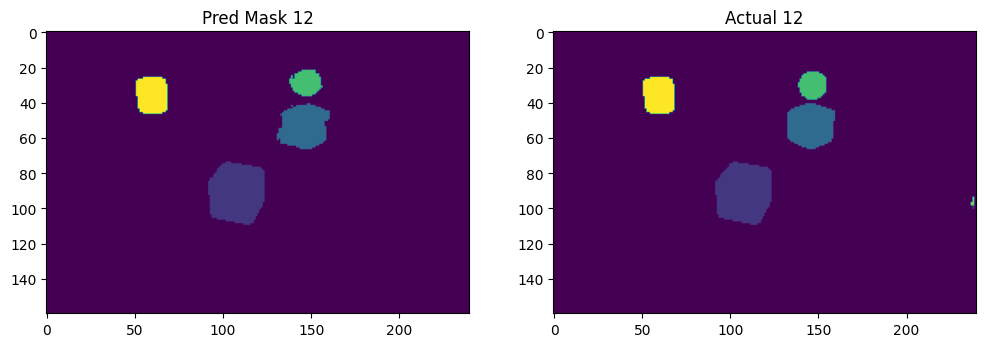

In [15]:
print(output.shape)
output_example = output[0,:]
print(output_example.shape)
output_example = torch.argmax(output_example, dim=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(output_example.cpu().numpy())
ax1.set_title("Pred Mask 12")
ax2.imshow(target[0].cpu().numpy())
ax2.set_title("Actual 12")
plt.show()

In [ ]:
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,10:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+10]   
  output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [ ]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))